# Import Model

In [72]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

In [71]:
!pip install keras



# Đọc dữ liệu từ Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mô tả dữ liệu

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/DataFlow_LSTM/final_train_output_1.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/DataFlow_LSTM/final_test_output_1.csv')

In [96]:
feature_cols = [
    'SaleFact_Year__x',
    'SaleFact_Month__x',
    'SaleFact_Is_business_',
    'SaleFact_COGS_SUM',
    'SaleFact_COGS_MEAN',
    'SaleFact_COGS_MAX',
    'SaleFact_Cost_per_unit_SUM',
    'SaleFact_Zip_SIZE',
    'SaleFact_Units_SUM',
    'SaleFact_Units_MAX',
    'Units_Lag_30',
    'Units_Rolling_Mean_7',
    'Units_Rolling_Std_7',
    'Units_Rolling_Std_30',
    'District_Encoded',
    'Zip_Prefix'
]

target_col = 'Target'  # cột cần dự báo

# tách X, y cho train và test
X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df[target_col].copy()

time_train = X_train['SaleFact_Year__x'].astype(str) + '-' + X_train['SaleFact_Month__x'].astype(str)
time_test  = X_test['SaleFact_Year__x'].astype(str) + '-' + X_test['SaleFact_Month__x'].astype(str)
time_train = pd.to_datetime(time_train)
time_test = pd.to_datetime(time_test)
print("\nFeature columns:", feature_cols)
print("Target column:", target_col)


Feature columns: ['SaleFact_Year__x', 'SaleFact_Month__x', 'SaleFact_Is_business_', 'SaleFact_COGS_SUM', 'SaleFact_COGS_MEAN', 'SaleFact_COGS_MAX', 'SaleFact_Cost_per_unit_SUM', 'SaleFact_Zip_SIZE', 'SaleFact_Units_SUM', 'SaleFact_Units_MAX', 'Units_Lag_30', 'Units_Rolling_Mean_7', 'Units_Rolling_Std_7', 'Units_Rolling_Std_30', 'District_Encoded', 'Zip_Prefix']
Target column: Target


#MinMaxScaler

In [55]:
scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

# fit scaler trên train, transform cho cả train và test
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

# chuyển thành mảng 2 chiều
y_train_2d = y_train.values.reshape(-1, 1)
y_test_2d  = y_test.values.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_2d)
y_test_scaled  = scaler_y.transform(y_test_2d)

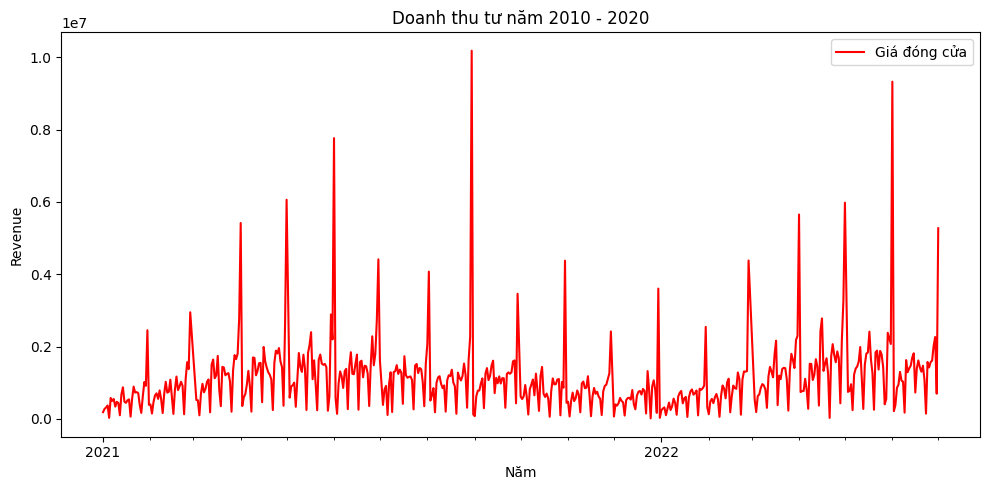

In [123]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
test_df['SaleFact_Date_'] = pd.to_datetime(test_df['SaleFact_Date_'], format='%Y-%m-%d')

# Lấy thông tin năm từ cột "Ngày"
test_df['Năm'] = test_df['SaleFact_Date_'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(test_df['SaleFact_Date_'], test_df['Target'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Revenue')
plt.title('Doanh thu tư năm 2010 - 2020')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()


#Tạo sequence cho LTSM

In [109]:


def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps), :])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

look_back = 50
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps=look_back)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled,  y_test_scaled,  time_steps=look_back)


print("x_train:", X_train_seq)
print("y_train: " ,y_train_seq)

x_train: [[[0.         0.54545455 0.         ... 0.02631579 0.20912125 0.1009838 ]
  [0.         0.54545455 1.         ... 0.31578947 0.05784205 0.08155702]
  [0.         0.54545455 1.         ... 0.31578947 0.06674082 0.0172492 ]
  ...
  [0.         0.63636364 0.         ... 0.94736842 0.90878754 0.0891975 ]
  [0.         0.63636364 1.         ... 0.78947368 0.56618465 0.08885212]
  [0.         0.63636364 1.         ... 0.44736842 0.42936596 0.08236288]]

 [[0.         0.54545455 1.         ... 0.31578947 0.05784205 0.08155702]
  [0.         0.54545455 1.         ... 0.31578947 0.06674082 0.0172492 ]
  [0.         0.54545455 1.         ... 0.02631579 0.5862069  0.05990983]
  ...
  [0.         0.63636364 1.         ... 0.78947368 0.56618465 0.08885212]
  [0.         0.63636364 1.         ... 0.44736842 0.42936596 0.08236288]
  [0.         0.63636364 1.         ... 0.02631579 0.00333704 0.07660829]]

 [[0.         0.54545455 1.         ... 0.31578947 0.06674082 0.0172492 ]
  [0.        

# build và train model

In [74]:
model = Sequential()
# layer đầu
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.5))

#layer tiếp
model.add(LSTM(units=64))
model.add(Dropout(0.5))

# lớp dense đầu ra
model.add(Dense(1))

model.compile(loss='mean_absolute_error',optimizer='adam')
model.summary()


# Train

#huấn luyện mô hình
save_model = "/content/drive/MyDrive/DataFlow_LSTM/save_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(X_train_seq, y_train_seq,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 50, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,225 (485.25 KB)

 Trainable params: 124,225 (485.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: loss improved from inf to 0.06800, saving model to /content/drive/MyDrive/DataFlow_LSTM/save_model.keras
74/74 - 17s - 224ms/step - loss: 0.0680
Epoch 2/100

Epoch 2: loss improved from 0.06800 to 0.04853, saving model to /content/drive/MyDrive/DataFlow_LSTM/save_model.keras
74/74 - 21s - 287ms/step - loss: 0.0485
Epoch 3/100

Epoch 3: loss improved from 0.04853 to 0.04501, saving model to /content/drive/MyDrive/DataFlow_LSTM/save_model.keras
74/74 - 20s - 276ms/step - loss: 0.0450
Epoch 4/100

Epoch 4: loss improved from 0.04501 to 0.04306, saving model to /content/drive/MyDrive/DataFlow_LSTM/save_model.keras
74/74 - 21s - 279ms/step - loss: 0.0431
Epoch 5/100

Epoch 5: loss improved from 0.04306 to 0.04165, saving model to /content/drive/MyDrive/DataFlow_LSTM/save_model.keras
74/74 - 11s - 154ms/step - loss: 0.0417
Epoch 6/100

Epoch 6: loss improved from 0.04165 to 0.04027, saving model to /content/drive/MyDrive/DataFlow_LSTM/save_model.keras
74/74 - 12s - 158m

# Dữ liệu train

In [80]:
y_train_seq = scaler_y.inverse_transform(y_train_seq)
final_model = load_model("/content/drive/MyDrive/DataFlow_LSTM/save_model.keras")
y_pred_scaled = final_model.predict(X_train_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step


# Đánh giá mô hình

In [133]:
import math
from sklearn.metrics import r2_score, mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#dữ liệu train
y_train_seq = scaler_y.inverse_transform(y_train_seq)
final_model = load_model("/content/drive/MyDrive/DataFlow_LSTM/save_model.keras")
#predict
y_pred_scaled = final_model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_true = scaler_y.inverse_transform(y_test_seq)

# tính các chỉ số
r2   = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = math.sqrt(mean_squared_error(y_true, y_pred))

print("\n--- EVALUATION METRICS ---")
print(f"R2   : {r2:.4f}")
print(f"MAPE : {mape:.4f} %")
print(f"RMSE : {rmse:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

--- EVALUATION METRICS ---
R2   : 0.3757
MAPE : 47.5241 %
RMSE : 815652.4577


# Vẽ biểu đồ

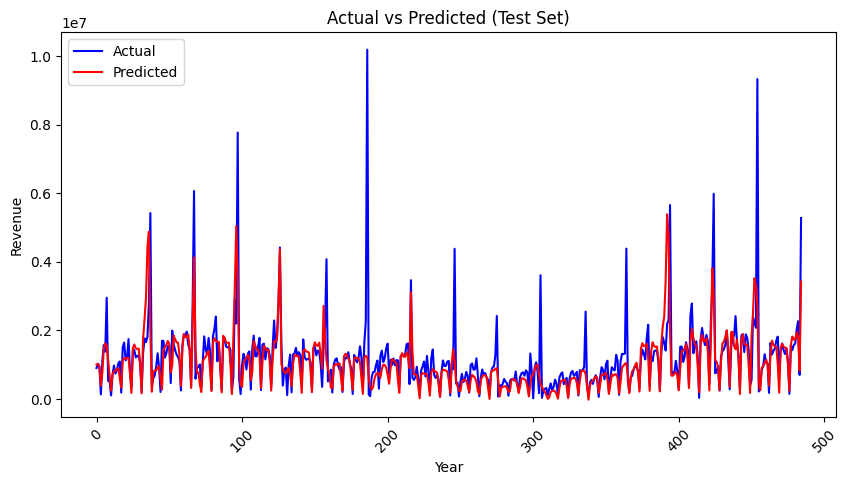

In [137]:

plt.figure(figsize=(10,5))
plt.plot( y_true, label='Actual', color='blue')
plt.plot( y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.xticks(rotation=45)  # Xoay nhãn trục X để dễ nhìn hơn
plt.legend()
plt.show()
